In [689]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from scipy.stats import norm
from sklearn.metrics import r2_score

In [690]:
# Laste poll-of-polls data
df = pd.read_csv("../data/v2_data_juli.csv", sep=",")

In [691]:
df

,Mnd,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,...,Rodt_reg_lag3,Rodt_reg_lag6,Andre_reg_lag3,Andre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
0,1/31/2008,29.3,17.2,23.9,7.4,6.1,6.4,6.5,0.0,1.3,...,NaN,NaN,NaN,NaN,2.6,NaN,NaN,5.25,NaN,NaN
1,2/29/2008,29.0,17.3,25.2,6.7,5.9,6.3,6.6,0.0,1.3,...,NaN,NaN,NaN,NaN,2.6,NaN,NaN,5.25,NaN,NaN
2,3/31/2008,28.7,18.1,25.2,7.0,5.6,6.1,6.3,0.0,1.1,...,0.0,NaN,0.0,NaN,2.6,0.000,NaN,5.25,0.000000,NaN
3,4/30/2008,29.0,16.9,25.4,6.5,5.5,7.0,6.8,0.0,1.2,...,0.0,NaN,0.0,NaN,2.7,0.033,NaN,5.31,0.020000,NaN
4,5/31/2008,28.9,17.8,25.9,6.7,5.7,6.2,6.2,0.0,1.4,...,0.0,NaN,0.0,NaN,2.8,0.067,NaN,5.50,0.083333,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,5/31/2025,28.5,18.7,20.6,7.0,5.7,3.6,4.1,2.7,5.3,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.20,-0.100000,-0.050000
209,6/30/2025,28.3,16.2,21.0,6.9,5.6,3.7,4.5,3.0,6.2,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.20,0.000000,-0.050000
210,7/31/2025,27.7,14.8,21.5,8.2,6.3,3.2,4.7,3.5,5.9,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.00,-0.066667,-0.083333
211,8/31/2025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,4.0,0.000,0.000000,4.00,-0.066667,-0.083333


In [692]:
ex_future=df[df['Ap'].isna()][['Mnd',
       'Ap_skandale_lag6', 'Hoyre_skandale_lag6', 'Frp_skandale_lag6',
       'SV_skandale_lag6', 'SP_skandale_lag6', 'KrF_skandale_lag6',
        'Rodt_skandale_lag6',
        'Ap_reg_lag6',
        'Hoyre_reg_lag6', 
        #'Frp_reg_lag6','SV_reg_lag6', 
        #'SP_reg_lag6','KrF_reg_lag6',
        #'Venstre_reg_lag6', 
       'ledighet', 'ledig_trend3', 'ledig_trend6', 'styringsrente',
       'styringsrente_trend3', 'styringsrente_trend6']]

In [693]:
ex_future
ex_future["Mnd"] = pd.to_datetime(df["Mnd"])
ex_future.set_index("Mnd", inplace=True)

In [694]:
df.dropna(inplace=True)

In [695]:
df

,Mnd,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,...,Rodt_reg_lag3,Rodt_reg_lag6,Andre_reg_lag3,Andre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
5,6/30/2008,26.0,17.6,28.9,6.9,5.3,6.1,5.9,0.0,1.8,...,0.0,0.0,0.0,0.0,2.9,0.067,0.050000,5.54,0.076667,0.048333
6,7/31/2008,26.9,17.2,30.2,6.6,4.7,6.1,5.4,0.0,1.9,...,0.0,0.0,0.0,0.0,2.9,0.033,0.050000,5.75,0.083333,0.083333
7,8/31/2008,26.6,16.2,30.9,6.7,5.2,5.5,6.0,0.0,1.7,...,0.0,0.0,0.0,0.0,3.0,0.033,0.066667,5.75,0.070000,0.083333
8,9/30/2008,28.9,15.2,29.9,6.3,5.0,5.7,5.9,0.0,1.5,...,0.0,0.0,0.0,0.0,3.1,0.067,0.066667,5.75,0.000000,0.073333
9,10/31/2008,30.6,16.1,26.7,7.3,5.3,5.6,5.5,0.0,1.2,...,0.0,0.0,0.0,0.0,3.1,0.033,0.050000,5.45,-0.100000,-0.008333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,3/31/2025,28.1,18.8,22.7,7.2,4.9,3.1,4.3,2.7,4.6,...,0.0,0.0,0.0,0.0,4.0,-0.033,0.000000,4.50,0.000000,0.000000
207,4/30/2025,28.1,19.8,20.0,6.3,6.7,3.3,3.9,3.1,4.8,...,0.0,0.0,0.0,0.0,4.0,-0.033,-0.016667,4.20,-0.100000,-0.050000
208,5/31/2025,28.5,18.7,20.6,7.0,5.7,3.6,4.1,2.7,5.3,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.20,-0.100000,-0.050000
209,6/30/2025,28.3,16.2,21.0,6.9,5.6,3.7,4.5,3.0,6.2,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.20,0.000000,-0.050000


In [696]:
# Convert to datetime and set the date to the end of the month
df["Mnd"] = pd.to_datetime(df["Mnd"])

In [697]:
# Sort values and set index
df = df.sort_values("Mnd")
df.set_index("Mnd", inplace=True)

In [698]:
df

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre,...,Rodt_reg_lag3,Rodt_reg_lag6,Andre_reg_lag3,Andre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
Mnd,,,,,,,,,,,,,,,,,,,,,
2008-06-30,26.0,17.6,28.9,6.9,5.3,6.1,5.9,0.0,1.8,0.0,...,0.0,0.0,0.0,0.0,2.9,0.067,0.050000,5.54,0.076667,0.048333
2008-07-31,26.9,17.2,30.2,6.6,4.7,6.1,5.4,0.0,1.9,0.0,...,0.0,0.0,0.0,0.0,2.9,0.033,0.050000,5.75,0.083333,0.083333
2008-08-31,26.6,16.2,30.9,6.7,5.2,5.5,6.0,0.0,1.7,0.0,...,0.0,0.0,0.0,0.0,3.0,0.033,0.066667,5.75,0.070000,0.083333
2008-09-30,28.9,15.2,29.9,6.3,5.0,5.7,5.9,0.0,1.5,0.0,...,0.0,0.0,0.0,0.0,3.1,0.067,0.066667,5.75,0.000000,0.073333
2008-10-31,30.6,16.1,26.7,7.3,5.3,5.6,5.5,0.0,1.2,0.0,...,0.0,0.0,0.0,0.0,3.1,0.033,0.050000,5.45,-0.100000,-0.008333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-31,28.1,18.8,22.7,7.2,4.9,3.1,4.3,2.7,4.6,3.4,...,0.0,0.0,0.0,0.0,4.0,-0.033,0.000000,4.50,0.000000,0.000000
2025-04-30,28.1,19.8,20.0,6.3,6.7,3.3,3.9,3.1,4.8,3.9,...,0.0,0.0,0.0,0.0,4.0,-0.033,-0.016667,4.20,-0.100000,-0.050000
2025-05-31,28.5,18.7,20.6,7.0,5.7,3.6,4.1,2.7,5.3,3.8,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.20,-0.100000,-0.050000


In [699]:
df_en=df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]
df_en = df_en.diff().dropna()  # Difference to make stationary
df_orig=df

In [700]:
df_ex=df[[
       'Ap_skandale_lag6', 'Hoyre_skandale_lag6', 'Frp_skandale_lag6',
       'SV_skandale_lag6', 'SP_skandale_lag6', 'KrF_skandale_lag6',
       #'Venstre_skandale_lag6', 
        #'MDG_skandale_lag6', 
       'Rodt_skandale_lag6',
       #'Andre_skandale_lag6', 
       # 'Ap_reg', 'Hoyre_reg', 'Frp_reg', 'SV_reg',
       #'SP_reg', 'KrF_reg', 'Venstre_reg', 'MDG_reg', 'Rodt_reg', 'Andre_reg',
       #'Ap_reg_lag3', 
       'Ap_reg_lag6',
        'Hoyre_reg_lag6', 
       # 'Frp_reg_lag6','SV_reg_lag6', 
       # 'SP_reg_lag6','KrF_reg_lag6',
       # 'Venstre_reg_lag6', 
        #'MDG_reg_lag6',
        #'Rodt_reg_lag6', 
        #'Andre_reg_lag6',
       'ledighet', 'ledig_trend3', 'ledig_trend6', 'styringsrente',
       'styringsrente_trend3', 'styringsrente_trend6']].iloc[1:]

In [701]:
df_ex

,Ap_skandale_lag6,Hoyre_skandale_lag6,Frp_skandale_lag6,SV_skandale_lag6,SP_skandale_lag6,KrF_skandale_lag6,Rodt_skandale_lag6,Ap_reg_lag6,Hoyre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
Mnd,,,,,,,,,,,,,,,
2008-07-31,1.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,2.9,0.033,0.050000,5.75,0.083333,0.083333
2008-08-31,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,3.0,0.033,0.066667,5.75,0.070000,0.083333
2008-09-30,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,3.1,0.067,0.066667,5.75,0.000000,0.073333
2008-10-31,1.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,3.1,0.033,0.050000,5.45,-0.100000,-0.008333
2008-11-30,1.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,3.1,0.000,0.033333,4.75,-0.333333,-0.131667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,4.0,-0.033,0.000000,4.50,0.000000,0.000000
2025-04-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,4.0,-0.033,-0.016667,4.20,-0.100000,-0.050000
2025-05-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,4.0,0.000,-0.016667,4.20,-0.100000,-0.050000


In [702]:
model = VARMAX(endog=df_en, exog=df_ex, order=(6,0), trend='c')
model_fitted = model.fit(disp=False)

print(model_fitted.summary())

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                                        Statespace Model Results                                                        
Dep. Variable:     ['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt', 'Andre']   No. Observations:                  205
Model:                                                                                  VARX(6)   Log Likelihood               -1565.531
                                                                                    + intercept   AIC                           4761.063
Date:                                                                          Tue, 19 Aug 2025   BIC                           7469.316
Time:                                                                                  11:10:27   HQIC                          5856.486
Sample:                                                                              07-31-2008                                         
                                         

In [703]:
#model = VAR(endog=df_en, exog=df_ex)

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [704]:
#model_fitted = model.fit(maxlags=6,method = 'ols', trend='c', verbose=True, ic='fpe')
#print(model_fitted.summary())

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 2, BIC -> 0, FPE -> 1, HQIC ->  0>
Using 1 based on fpe criterion
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 19, Aug, 2025
Time:                     11:10:28
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -8.44129
Nobs:                     204.000    HQIC:                  -10.9596
Log likelihood:          -1342.27    FPE:                3.18733e-06
AIC:                     -12.6703    Det(Omega_mle):     9.60396e-07
--------------------------------------------------------------------
Results for equation Ap
                          coefficient        std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                        0.002574  102257013.14939

In [733]:
# Compute R² for each party
r2_scores = {}
for party in ['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']:
    r2_scores[party] = r2_score(df_en[party].iloc[model_fitted.k_ar:], model_fitted.fittedvalues[party])

# Print R² values
for party, r2 in r2_scores.items():
    print(f"R² for {party}: {r2:.4f}")

ValueError: Found input variables with inconsistent numbers of samples: [205, 204]

In [706]:
# Check if the VAR model is stable (roots inside the unit circle)
print("Is the VAR model stable?", model_fitted.is_stable())

Is the VAR model stable? True


In [707]:
all_fitted= model_fitted.fittedvalues

In [708]:
all_fitted

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre
Mnd,,,,,,,,,,
2008-08-31,-0.421286,-0.382734,0.431971,0.104668,0.253850,0.021790,0.044311,0.063496,-0.038601,-0.254959
2008-09-30,1.013134,-0.800098,-0.322675,0.083569,0.006131,0.243429,-0.324638,0.061741,-0.004420,-0.090418
2008-10-31,0.914836,-0.778237,-0.195564,0.229613,0.071214,-0.116085,0.094750,-0.001948,-0.182922,-0.094592
2008-11-30,0.893432,0.294939,-0.603651,-0.087265,-0.379691,0.210084,0.131314,-0.201921,-0.362215,-0.162848
2008-12-31,0.224817,1.222360,-0.454369,0.083084,-0.241220,-0.330422,-0.208891,-0.039241,-0.458367,-0.235683
...,...,...,...,...,...,...,...,...,...,...
2025-03-31,1.234202,-0.642014,0.145834,-0.438846,-0.125583,0.054006,0.123745,-0.045281,-0.144787,-0.010443
2025-04-30,0.653220,-0.693880,-0.302666,-0.149442,0.565462,0.137721,0.123642,-0.101256,0.073434,-0.294137
2025-05-31,0.419658,-0.313239,-0.106936,0.345270,-0.177342,-0.066013,0.131592,-0.138666,-0.031042,-0.078022


In [709]:
steps = 2  # Number of steps to forecast
alpha = 0.1

forecast, lower, upper = model_fitted.forecast_interval(df_en.values[-model_fitted.k_ar:],  exog_future=ex_future, steps=steps, alpha=alpha)


In [710]:
forecast

array([[ 0.59790762, -0.70470399, -0.25490546, -0.29342625,  0.27197468,
         0.45852575, -0.02359377, -0.25421825,  0.02305221, -0.03638871],
       [ 0.93148247, -0.61094975,  0.13523992, -0.17937665,  0.12498954,
        -0.23669361,  0.00466449,  0.02550505, -0.08471283, -0.09261075]])

In [711]:
forecast_dates = pd.date_range(start="2025-08-31", periods=steps, freq='ME')

last_actual_value = df_orig.iloc[-1]  # Last known actual data point

forecast_df = pd.DataFrame(forecast, index=forecast_dates, columns=df_en.columns)
forecast_lower_df=pd.DataFrame(lower, index=forecast_dates, columns=df_en.columns)
forecast_upper_df=pd.DataFrame(upper, index=forecast_dates, columns=df_en.columns)

forecast_df = forecast_df.cumsum() + last_actual_value
forecast_lower_df = forecast_lower_df.cumsum() + last_actual_value
forecast_upper_df = forecast_upper_df.cumsum() + last_actual_value

In [712]:
# Get forecast covariance in differenced scale
forecast_cov = model_fitted.forecast_cov(steps=steps)

# Cumulative sum of covariance matrices to restore original scale
for t in range(steps):
    forecast_cov[t] = np.sum(forecast_cov[:t+1], axis=0)

# Convert to DataFrames for readability
forecast_cov_df = {t: pd.DataFrame(forecast_cov[t], index=df_en.columns, columns=df_en.columns)
                            for t in range(steps)}

In [713]:
df_en=df_orig

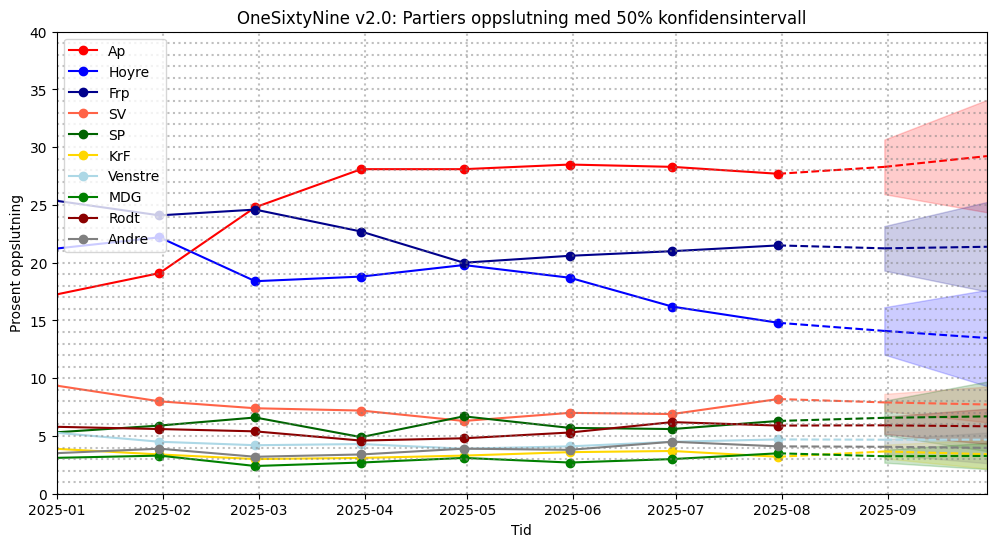

In [714]:
# Define a color map for consistency
colors = {
    'Ap': '#FF0000',        # Red
    'Hoyre': '#0000FF',     # Blue
    'Frp': '#00008B',       # Dark Blue
    'SV': '#FF6347',        # Light Red (Tomato)
    'SP': '#006400',        # Dark Green
    'KrF': '#FFD700',       # Yellow (Gold)
    'Venstre': '#ADD8E6',   # Light Blue
    'MDG': '#008000',       # Green
    'Rodt': '#8B0000',      # Dark Red
    'Andre': '#808080'      # Gray
}

plt.figure(figsize=(12, 6))

for party in colors.keys():  # Iterate over defined parties
    color = colors[party]  

    # Plot actual data
    plt.plot(df_en.index, df_en[party], marker="o", color=color, label=f"{party}")

    # Plot forecast 
    plt.plot(forecast_df.index, forecast_df[party], linestyle="dashed", color=color)

    last_actual_date = df_en.index[-1]
    first_forecast_date = forecast_df.index[0]
    last_actual_value = df_en[party].iloc[-1]
    first_forecast_value = forecast_df[party].iloc[0]

    plt.plot([last_actual_date, first_forecast_date], [last_actual_value, first_forecast_value], color=color, linestyle="dashed")
    
    # Plot confidence interval (original scale)
    plt.fill_between(forecast_df.index, 
                     forecast_lower_df[party], 
                     forecast_upper_df[party], 
                     color=color, alpha=0.2)


dates = pd.date_range(start="2023-01-01", end="2025-09-30", freq="MS") 
for date in dates:
    plt.axvline(date, color="gray", linestyle="dotted", alpha=0.5)

# Add horizontal grid lines every 5%
for percent in range(0, 45, 1):
    plt.axhline(percent, color="gray", linestyle="dotted", alpha=0.5)

plt.xlim(np.datetime64("2025-01-01"), np.datetime64("2025-09-30"))  # Manually set max date to Sept 2025
plt.ylim(0,40)  # Manually set max date to Sept 2025
plt.xlabel("Tid")
plt.ylabel("Prosent oppslutning")
plt.title("OneSixtyNine v2.0: Partiers oppslutning med 50% konfidensintervall")
plt.legend(loc="upper left")
plt.show()

In [715]:
forecast_df=forecast_df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]
forecast_lower_df=forecast_lower_df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]
forecast_upper_df=forecast_upper_df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]

In [716]:
###finn estimat for september
date_to_extract = "2025-09-30"

# Extract the row for the given date from each dataframe
estimate_row = forecast_df.loc[date_to_extract]
lower_row = forecast_lower_df.loc[date_to_extract]
upper_row = forecast_upper_df.loc[date_to_extract]

# Combine into a new DataFrame
result_df = pd.DataFrame({
    "Party": estimate_row.index,
    "Estimate": estimate_row.values,
    "Lower": lower_row.values,
    "Upper": upper_row.values
})

# Display the final structured DataFrame
print(result_df)

     Party   Estimate      Lower      Upper
0       Ap  29.229390  24.364979  34.093802
1    Hoyre  13.484346   9.319948  17.648744
2      Frp  21.380334  17.503192  25.257477
3       SV   7.727197   6.182051   9.272343
4       SP   6.696964   3.685960   9.707968
5      KrF   3.421832   2.168052   4.675612
6  Venstre   4.681071   3.269775   6.092367
7      MDG   3.271287   2.128153   4.414420
8     Rodt   5.838339   4.316725   7.359954
9    Andre   3.971001   2.641366   5.300635


In [717]:
# Multivariate MC!
n_sim = 1000000
# Extract mean estimates (yhat) and covariance matrix
yhat_vector = result_df["Estimate"].values  # Mean estimates for all parties
#yhat_vector = forecast_original_scale["Estimate"].values  # Mean estimates for all parties
cov_matrix = forecast_cov[-1]  # Covariance matrix at final step (latest forecast)

# Generate correlated samples
samples = np.random.multivariate_normal(yhat_vector, cov_matrix, size=n_sim)
samples = np.maximum(samples, 1e-6) ##must be above 0
samples = (samples.T / samples.sum(axis=1) * 100).T

# Create a DataFrame with sampled values
sampled_df = pd.DataFrame(samples, columns=result_df["Party"])

# Compute vote totals for each simulation
red_green_votes = sampled_df[["Ap", "SV", "SP", "Rodt", "MDG"]].sum(axis=1)/sampled_df.sum(axis=1)
blue_votes = sampled_df[["Hoyre", "Frp", "KrF", "Venstre"]].sum(axis=1)/sampled_df.sum(axis=1)

# Probability that red-green block wins
prob_red_green_wins = np.mean(red_green_votes > blue_votes)

print(f"Sannsyn for at Ap+SV+Sp+R+MDG > H+FrP+KrF+V: {prob_red_green_wins:.4f}")


Sannsyn for at Ap+SV+Sp+R+MDG > H+FrP+KrF+V: 0.9916


In [718]:
sampled_df.drop(columns=["Andre"], inplace=True)

In [719]:
sample_mandate=pd.DataFrame(columns=sampled_df.columns)

In [720]:
def calc_mandat(oppslutt):
    if oppslutt <4.0:
        mandat=np.round(1/4*oppslutt**2,0)
    else: 
        oppslutt=round(1.8119*oppslutt,0)
    return int(oppslutt)

In [721]:
for party in sampled_df.columns:
    sample_mandate[party]=sampled_df[party].apply(calc_mandat)

In [722]:
sample_mandate

Party,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt
0,50,27,40,15,12,2,9,3,12
1,56,28,36,12,10,7,8,3,9
2,45,27,38,13,19,3,10,3,9
3,55,23,38,16,7,3,9,3,11
4,53,24,37,14,14,3,9,8,10
...,...,...,...,...,...,...,...,...,...
999995,48,32,38,14,11,2,8,2,12
999996,52,31,31,12,15,3,10,2,12
999997,52,23,40,17,12,7,9,3,9
999998,56,26,38,14,11,3,8,2,13


In [723]:
sample_mandate['Sum']=sample_mandate.sum(axis=1)

In [724]:
sample_mandate

Party,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Sum
0,50,27,40,15,12,2,9,3,12,170
1,56,28,36,12,10,7,8,3,9,169
2,45,27,38,13,19,3,10,3,9,167
3,55,23,38,16,7,3,9,3,11,165
4,53,24,37,14,14,3,9,8,10,172
...,...,...,...,...,...,...,...,...,...,...
999995,48,32,38,14,11,2,8,2,12,167
999996,52,31,31,12,15,3,10,2,12,168
999997,52,23,40,17,12,7,9,3,9,172
999998,56,26,38,14,11,3,8,2,13,171


In [725]:
sample_169=sample_mandate[sample_mandate["Sum"]==169].copy()

In [726]:
sample_169

Party,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Sum
1,56,28,36,12,10,7,8,3,9,169
15,54,21,38,16,13,3,9,3,12,169
30,49,25,39,14,15,3,9,3,12,169
31,51,24,43,13,12,3,10,2,11,169
34,57,23,39,13,14,3,9,3,8,169
...,...,...,...,...,...,...,...,...,...,...
999974,52,27,40,14,10,3,10,3,10,169
999980,55,24,42,14,10,3,9,2,10,169
999982,56,19,41,14,10,7,10,3,9,169
999987,54,23,40,13,12,3,8,7,9,169


In [727]:
sample_169['red_green'] = sample_169[["Ap", "SV", "SP", "Rodt", "MDG"]].sum(axis=1)
sample_169['ap_sp'] = sample_169[["Ap", "SP"]].sum(axis=1)
sample_169['ap_sp_sv'] = sample_169[["Ap", "SP", "SV"]].sum(axis=1)
sample_169['ap_sp_sv_r'] = sample_169[["Ap", "SP", "SV", "Rodt"]].sum(axis=1)
sample_169['ap_sp_sv_r_mdg'] = sample_169[["Ap", "SP", "SV", "Rodt", "MDG"]].sum(axis=1)
sample_169['h_frp'] = sample_169[["Hoyre", "Frp"]].sum(axis=1)
sample_169['h_frp_v_krf'] = sample_169[["Hoyre", "Frp", "Venstre", "KrF"]].sum(axis=1)
sample_169['h_frp_v_krf_mdg'] = sample_169[["Hoyre", "Frp", "Venstre", "KrF", "MDG"]].sum(axis=1)

In [728]:
sample_169['red_green_victory'] = sample_169['red_green'] >= 85
sample_169['ap_sp_victory'] = sample_169['ap_sp'] >= 85
sample_169['ap_sp_sv_victory'] = sample_169['ap_sp_sv'] >= 85
sample_169['ap_sp_sv_r'] = sample_169['ap_sp_sv_r'] >= 85
sample_169['ap_sp_sv_r_mdg'] = sample_169['ap_sp_sv_r_mdg'] >= 85
sample_169['h_frp'] = sample_169['h_frp'] >= 85
sample_169['h_frp_v_krf'] = sample_169['h_frp_v_krf'] >= 85
sample_169['h_frp_v_krf_mdg'] = sample_169['h_frp_v_krf_mdg'] >= 85

In [729]:
sample_169['r_avh'] = (sample_169['ap_sp_sv'] < 85) & (sample_169['ap_sp_sv_r']) >= 85

In [730]:
print(sample_169['red_green_victory'].mean())
print(sample_169['ap_sp_victory'].mean())
print(sample_169['ap_sp_sv_victory'].mean())
print(sample_169['ap_sp_sv_r'].mean())
print(sample_169['ap_sp_sv_r_mdg'].mean())
print(sample_169['h_frp'].mean())
print(sample_169['h_frp_v_krf'].mean())
print(sample_169['h_frp_v_krf_mdg'].mean())
print(sample_169['r_avh'].mean())

0.989202657807309
0.0
0.09916279069767442
0.93578073089701
0.989202657807309
0.0
0.01079734219269103
0.06421926910299003
0.0


In [731]:
sample_169.to_csv('sample.csv')

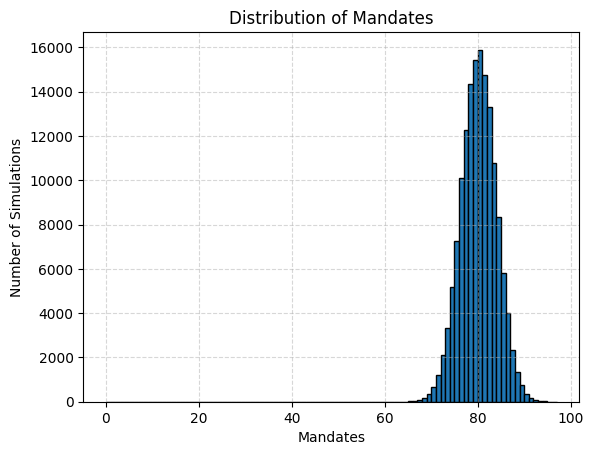

In [732]:
import matplotlib.pyplot as plt

plt.hist(sample_169['ap_sp_sv'], bins=range(0, sample_169['ap_sp_sv'].max() + 2), edgecolor='black')
plt.title('Distribution of Mandates')
plt.xlabel('Mandates')
plt.ylabel('Number of Simulations')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()